# Imports

In [2]:
import boto3
import sagemaker
from sagemaker import Session
from sagemaker.session import TrainingInput
from sagemaker.tensorflow import TensorFlow as tf
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
import tensorflow
import s3fs
import numpy as np
import json
import time
RANDOM_SEED = 0
sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


2025-08-16 09:04:49.993837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.245.0'

# Sagemaker Initialization

In [3]:
fs = s3fs.S3FileSystem()
sm = boto3.client("sagemaker")
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
s3 = boto3.client("s3")
bucket = sess.default_bucket()   # will be sagemaker-ap-southeast-2-838084669510
prefix = "aiornot"
print(f"S3 Bucket: f{bucket}")

s3_small_train_path = f"s3://{bucket}/{prefix}/small_train/small_train.npz"
s3_train_path = f"s3://{bucket}/{prefix}/train/train.npz"
s3_test_path = f"s3://{bucket}/{prefix}/test/test.npz"
s3_holdout_test_path = f"s3://{bucket}/{prefix}/holdout_test/holdout_test.npz"
s3_output_location = f"s3://{bucket}/{prefix}/model_output"

small_train_input = TrainingInput(s3_small_train_path, content_type="application/x-npz")
train_input = TrainingInput(s3_train_path, content_type="application/x-npz")
test_input = TrainingInput(s3_test_path, content_type="application/x-npz")


S3 Bucket: fsagemaker-ap-southeast-2-838084669510


# Hyperparameter Tuning on smaller training set

In [47]:
estimator = tf(
    entry_point="train.py",
    source_dir="src",  
    role=role,
    use_spot_instances=True,  # save money
    instance_type="ml.c5.2xlarge",
    instance_count=1,
    framework_version="2.14",
    py_version="py310",
    hyperparameters={
        "epochs": 3,
        "height": 512,
        "width": 512,
        "channels": 3
    },
    output_path=s3_output_location
)

hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(1e-4, 1e-2, scaling_type="Logarithmic"),
    "dropout-rate": ContinuousParameter(0.0, 0.5),                 # if use-dropout=true
    "batch-size": IntegerParameter(4, 8),                         # change range to suit memory
    "conv1-filters": IntegerParameter(16, 128),
    "conv2-filters": IntegerParameter(32, 256),
    "dense-units": IntegerParameter(64, 512),
    "pooling": CategoricalParameter(["max", "avg"]),
    "use-dropout": CategoricalParameter(["true", "false"]),
    "optimizer": CategoricalParameter(["adam", "adagrad"]),
}

metric_definitions = [
    {"Name": "val_auc",       "Regex": "val_auc: ([0-9\\.]+)"},
    {"Name": "val_f1",        "Regex": "val_f1: ([0-9\\.]+)"},
    {"Name": "val_precision", "Regex": "val_precision: ([0-9\\.]+)"},
    {"Name": "val_recall",    "Regex": "val_recall: ([0-9\\.]+)"},
    {"Name": "val_accuracy",  "Regex": "val_accuracy: ([0-9\\.]+)"},
]

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="val_f1",
    strategy='Hyperband',
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_parallel_jobs=5,
    objective_type="Maximize",
    # early_stopping_type="Auto", # not supported for hyperband strategy, since it gets rid of unpromising trials itself
    max_jobs=20,
    base_tuning_job_name="ph-17",
)

tuner.fit({
    "train": small_train_input,
    "test": test_input,
})


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: ph-17-250815-1154


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Get Best Hyperparameters and train on larger set

In [5]:
name = "ph-17-250815-1154"

# 1) Best job + objective metric
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=name)
desc

{'HyperParameterTuningJobName': 'ph-17-250815-1154',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:ap-southeast-2:838084669510:hyper-parameter-tuning-job/ph-17-250815-1154',
 'HyperParameterTuningJobConfig': {'Strategy': 'Hyperband',
  'StrategyConfig': {'HyperbandStrategyConfig': {'MinResource': 1,
    'MaxResource': 3}},
  'HyperParameterTuningJobObjective': {'Type': 'Maximize',
   'MetricName': 'val_f1'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 20,
   'MaxParallelTrainingJobs': 5},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'batch-size',
     'MinValue': '4',
     'MaxValue': '8',
     'ScalingType': 'Auto'},
    {'Name': 'conv1-filters',
     'MinValue': '16',
     'MaxValue': '128',
     'ScalingType': 'Auto'},
    {'Name': 'conv2-filters',
     'MinValue': '32',
     'MaxValue': '256',
     'ScalingType': 'Auto'},
    {'Name': 'dense-units',
     'MinValue': '64',
     'MaxValue': '512',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'N

In [7]:
sm = boto3.client("sagemaker")
training_job_name = "ph-17-250815-1154-018-22526da0"  
tj = sm.describe_training_job(TrainingJobName=training_job_name)
raw_hps = dict(tj["HyperParameters"])  # strings
raw_hps

def strip_wrapped_quotes(v: str) -> str:
    # turns '"adam"' -> adam ; "\"s3://...\"" -> s3://...
    if v and len(v) >= 2 and v[0] == '"' and v[-1] == '"':
        return v[1:-1]
    return v

# keys you don’t want to pass back to train.py
denylist_prefixes = ("sagemaker_", "_tuning_")
denylist_exact    = {"model_dir", "sagemaker_job_name", "sagemaker_program",
                     "sagemaker_region", "sagemaker_submit_directory"}

clean_hps = {}
for k, v in raw_hps.items():
    if k in denylist_exact or any(k.startswith(p) for p in denylist_prefixes):
        continue
    vv = strip_wrapped_quotes(v)
    clean_hps[k] = vv
clean_hps

int_keys   = {"epochs","height","width","channels","batch-size",
              "conv1-filters","conv2-filters","dense-units"}
float_keys = {"learning-rate","dropout-rate"}
bool_keys  = {"use-dropout"}  # expects "true"/"false" strings in argparse? keep as strings if so.

typed_hps = {}
for k, v in clean_hps.items():
    try:
        if k in int_keys:   typed_hps[k] = int(float(v))  # int might come as "5" or "5.0"
        elif k in float_keys: typed_hps[k] = float(v)
        elif k in bool_keys:  typed_hps[k] = v.lower() if v.lower() in ("true","false") else v
        else:                 typed_hps[k] = v
    except Exception:
        # if anything is odd, fall back to original string
        typed_hps[k] = v

print("Using hyperparameters:", typed_hps)

Using hyperparameters: {'batch-size': 8, 'channels': 3, 'conv1-filters': 24, 'conv2-filters': 107, 'dense-units': 254, 'dropout-rate': 0.28387290921651137, 'epochs': 3, 'height': 512, 'learning-rate': 0.0014935690608651416, 'optimizer': 'adam', 'pooling': 'max', 'use-dropout': 'true', 'width': 512}


# Train on the Larger Set

In [ ]:
train_npz = "s3://sagemaker-ap-southeast-2-838084669510/aiornot/small_train/small_train.npz"
test_npz  = "s3://sagemaker-ap-southeast-2-838084669510/aiornot/test/test.npz"

train_input = TrainingInput(train_npz, input_mode="File", content_type="application/x-npz")
test_input  = TrainingInput(test_npz,  input_mode="File", content_type="application/x-npz")

estimator = tf(
    entry_point="train.py",
    source_dir="src",
    role=role,
    instance_type="ml.c5.2xlarge",
    instance_count=1,
    framework_version="2.14",
    py_version="py310",
    output_path=f"s3://{bucket}/aiornot/model_output",
    # keep the static shape/run params you use + inject the tuned ones
    hyperparameters={
        "epochs": 5, "height": 512, "width": 512, "channels": 3,
        **typed_hps,  # tuned values win if keys overlap
    },
    metric_definitions=[
        {"Name":"val_auc","Regex":r"val_auc: ([0-9\.]+)"},
        {"Name":"val_f1","Regex":r"val_f1: ([0-9\.]+)"},
        {"Name":"val_precision","Regex":r"val_precision: ([0-9\.]+)"},
        {"Name":"val_recall","Regex":r"val_recall: ([0-9\.]+)"},
        {"Name":"val_accuracy","Regex":r"val_accuracy: ([0-9\.]+)"},
    ],
)
# Creating training-job with name: bestparams-refit-20250815-091227
job_name = "bestparams-refit-" + time.strftime("%Y%m%d-%H%M%S")
estimator.fit(
    {"train": train_input, "test": test_input},
    job_name=job_name
)

# Deploy the final Model

In [11]:

final_model_s3_path = "s3://sagemaker-ap-southeast-2-838084669510/aiornot/model_output/bestparams-refit-20250816-094717/output/model.tar.gz"
final_tf_model = TensorFlowModel(
    model_data=final_model_s3_path,
    role=role,
    framework_version="2.14"
)

predictor = final_tf_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="final-model-endpoint"
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-inference-2025-08-16-10-02-35-502
INFO:sagemaker:Creating endpoint-config with name final-model-endpoint
INFO:sagemaker:Creating endpoint with name final-model-endpoint


----!

In [12]:
from sklearn.metrics import classification_report, accuracy_score
# Load test set locally (you’ll need it locally for label comparison)
s3_holdout_test_path = "s3://sagemaker-ap-southeast-2-838084669510/aiornot/tiny_test/tiny_test.npz"
# 1) load
with fs.open(s3_holdout_test_path, "rb") as f:
    d = np.load(f)
    X = d["image"].astype("float32") 
    y_true = np.asarray(d["label"], dtype=int).ravel()
    print("data loaded")

# 3) predict in micro-batches to avoid 413
def predict_batches(pred, X, bs=1):
    probs = []
    for i in range(0, len(X), bs):
        out = pred.predict(X[i:i+bs].tolist())
        p = np.array(out.get("predictions", out)).reshape(-1)  # shape (bs,)
        probs.append(p)
        print(f"{i}/{len(X)}")
    return np.concatenate(probs)

probs = predict_batches(predictor, X, bs=1)
y_pred = (probs >= 0.5).astype(int)

In [13]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
metrics = {
    "precision": precision_score(y_true, y_pred, zero_division=0),
    "recall": recall_score(y_true, y_pred, zero_division=0),
    "f1": f1_score(y_true, y_pred, zero_division=0),
    "accuracy": accuracy_score(y_true, y_pred),
}
df_metrics = pd.DataFrame([metrics]).round(4)
df_metrics

,precision,recall,f1,accuracy
0,0.8182,0.9,0.8571,0.85


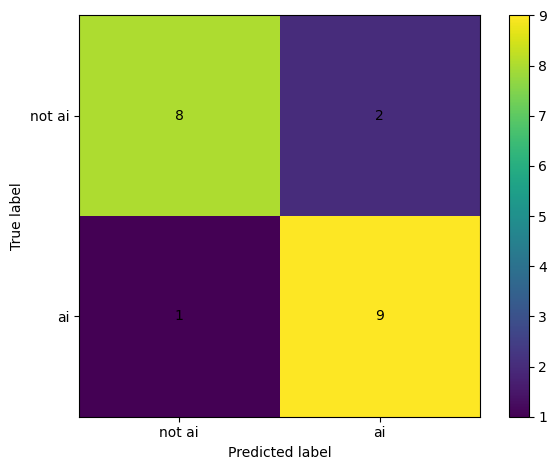

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["not ai", "ai"] 
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(2), labels=labels)
ax.set_yticks(np.arange(2), labels=labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()
